# Hugging Face Diffusers

In this notebook, we run through an example of generating MNIST digits using the Hugging Face `diffusers` library. As we will see, we will be able to produce high quality digits using only a CPU.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

### Define our model

In [24]:
model = UNet2DModel(
    sample_size=28,                # 28x28 input
    in_channels=1,                 # 1 channel (grayscale)
    out_channels=1,                # 1 channel output
    layers_per_block=1,            # 1 layer per block, this can make your model large
    block_out_channels=(4, 8, 16), # 3 blocks with 4, 8, and 16 channels
    down_block_types=(
        "DownBlock2D",             # A resnet block
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",               # Upsampling block
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=10,           # 10 class embeddings for the 10 digits
    norm_num_groups=2,             # 2 groups for normalization, you will have to change this if you change the number of channels in your blocks
)

In [25]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=4, out_features=16, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=16, out_features=16, bias=True)
  )
  (class_embedding): Embedding(10, 16)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
          (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=16, out_features=4, bias=True)
          (norm2): GroupNorm(2, 4, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): 

### Load data

In [26]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

DATA_PATH = '../data/'

train_dataset = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 

### Initialize the scheduler and optimizer

In [27]:
noise_scheduler = DDPMScheduler(num_train_timesteps=200,
                                beta_start = 0.0001,
                                beta_end = 0.02,
                                beta_schedule = 'linear',
                                prediction_type = 'epsilon'
                                )
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_train_steps = len(train_loader) * 3

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

Let's see what the model looks like when we try to generate without any training...

In [28]:
@torch.no_grad()
def sample(model: UNet2DModel,
              scheduler: DDPMScheduler,
              batch_size: int,
              generator: torch._C.Generator,
              num_inference_steps: int,
              label: int) -> np.ndarray:
    
    image_shape = (batch_size, 1, 28, 28)
    # if label is a list
    if isinstance(label, list):
        labels = torch.tensor(label)
    else:
        labels = torch.full((batch_size,), label)

    image = torch.randn(image_shape)

    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # 1. predict noise model_output
        model_output = model(image, t, labels).sample

        # 2. compute previous image: x_t -> x_t-1
        image = scheduler.step(model_output, t, image, generator=generator).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.permute(0, 2, 3, 1)

    return image.detach().numpy()

In [29]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

100%|██████████| 200/200 [00:04<00:00, 49.25it/s]


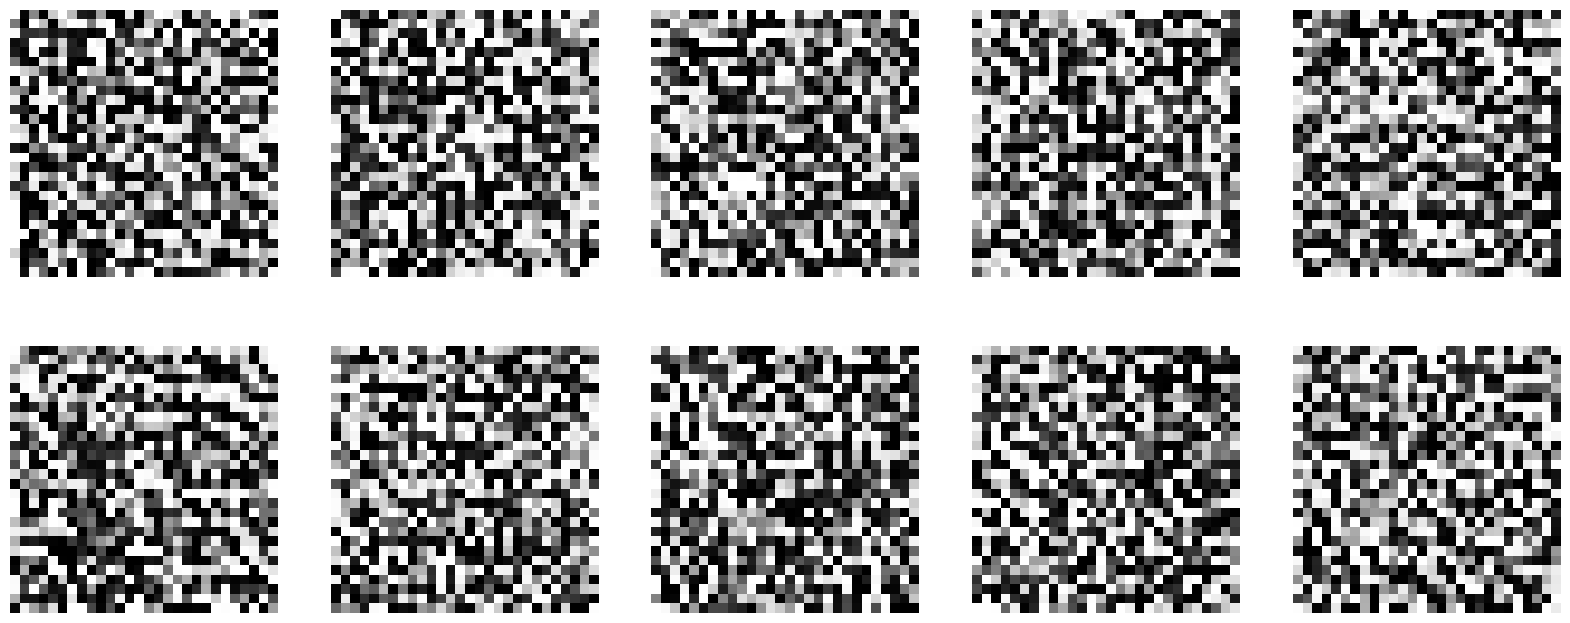

In [30]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

### Train the model

So that was obviously terrible... Let's train the model for a few epochs and see how it improves.

In [31]:
def train(
    model: UNet2DModel,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    noise_scheduler: DDPMScheduler,
    lr_scheduler,
    epochs: int,
):
    for epoch in range(epochs):
        model.train()
        for i, (clean_images, labels) in tqdm(enumerate(train_loader)):
            noise = torch.randn(clean_images.shape)
            bs = clean_images.shape[0]
            labels = labels

            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        
        print(f'Epoch {epoch} Loss: {loss.item()}')

train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    noise_scheduler=noise_scheduler,
    lr_scheduler=lr_scheduler,
    epochs=3,
)


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [02:12, 14.18it/s]


Epoch 0 Loss: 0.08168818056583405


1875it [02:20, 13.39it/s]


Epoch 1 Loss: 0.06413132697343826


1875it [02:00, 15.59it/s]

Epoch 2 Loss: 0.07496078312397003


Now let's try sampling again...

In [32]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

100%|██████████| 200/200 [00:03<00:00, 51.46it/s]


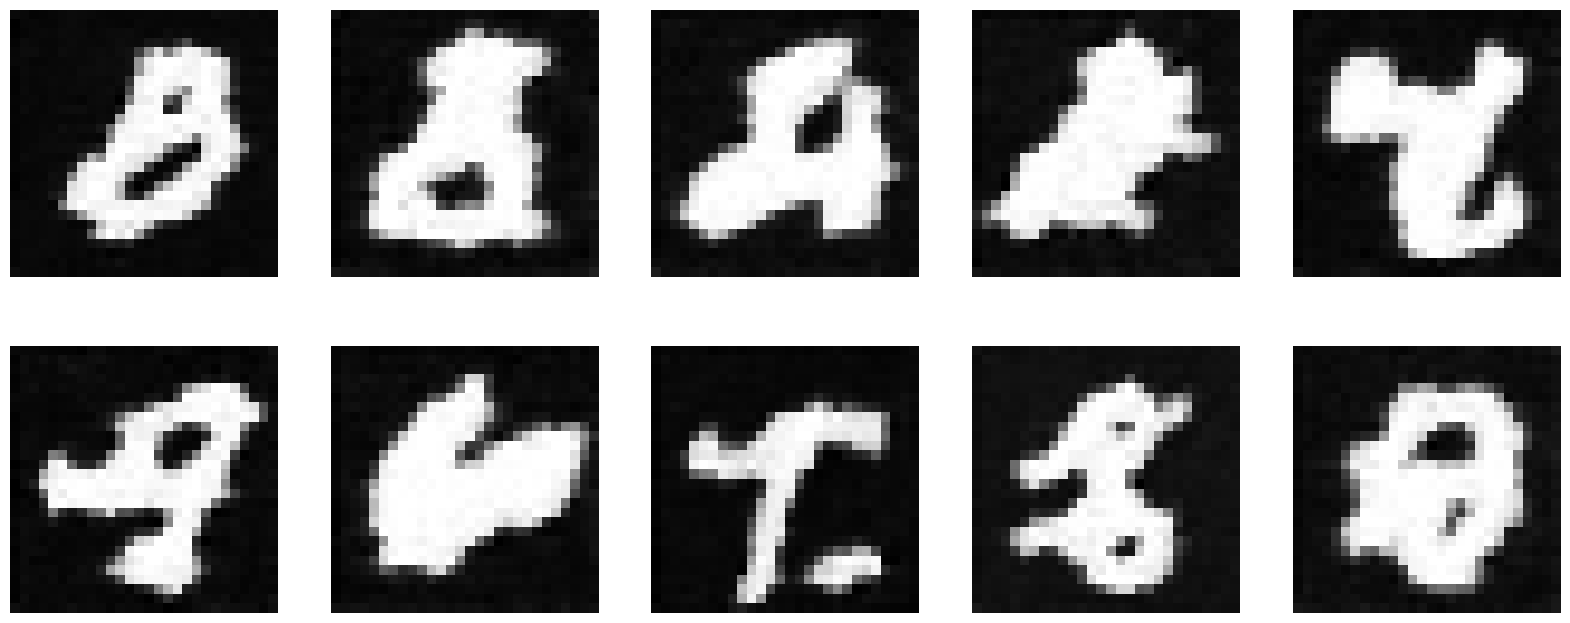

In [33]:
# show images

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

The model is definitely trying... some digits are recognizable, but many are not! Let's increase the number of layers per block and the size of the blocks to see if we can get some better results.

In [34]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(8, 16, 32),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=10,
    norm_num_groups=2,
)

In [35]:
noise_scheduler = DDPMScheduler(num_train_timesteps=200)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_train_steps = len(train_loader) * 5

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

In [5]:
train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    noise_scheduler=noise_scheduler,
    lr_scheduler=lr_scheduler,
    epochs=5,
)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [05:13,  5.98it/s]


Epoch 0 Loss: 0.05497313663363457


1875it [05:28,  5.71it/s]


Epoch 1 Loss: 0.03213882073760033


1875it [04:57,  6.30it/s]


Epoch 2 Loss: 0.033250607550144196


1875it [04:53,  6.38it/s]


Epoch 3 Loss: 0.031056445091962814


1875it [04:51,  6.44it/s]

Epoch 4 Loss: 0.03150348365306854


In [ ]:
# save model and scheduler
torch.save(model.state_dict(), 'model.pth')

In [19]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

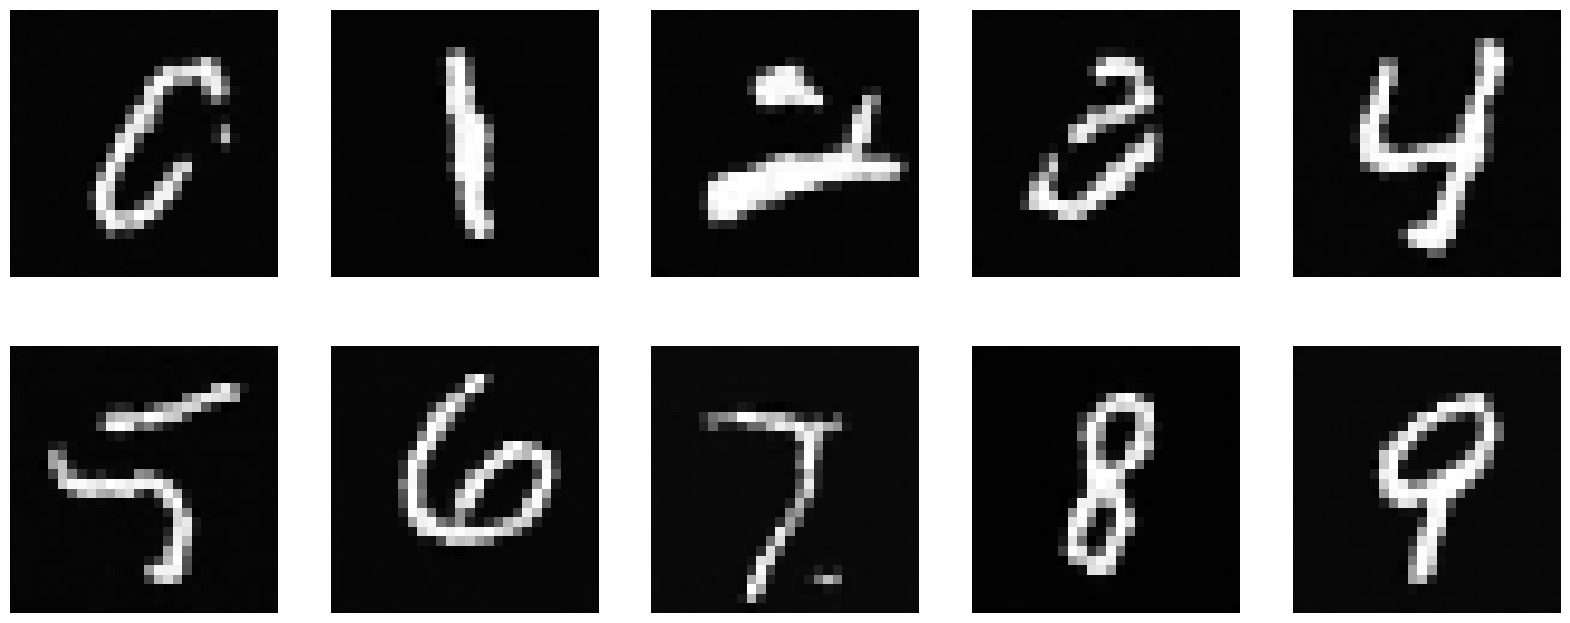

: 

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

That is significantly better! Just think about what we've managed to do here. We've trained a model to generate MNIST digits using only a CPU! This is a testament to the power of the `diffusers` library and the incredible work that the Hugging Face team has done to make it accessible to everyone. Having said that, these images are tiny in comparison to many images used in research today. In order to generate larger images, we would need to use a GPU.